# fMRI prepreprocessing - Hands-on session Part II

#### Max Planck School of Cognition, Methods in Cognitive Neuroscience, July 2021


##### Contact: Frauke Beyer @ Neurology Dept., MPI CBS, Leipzig, Germany, fbeyer@cbs.mpg.de

###### Please contact me if you have any questions or problems with the notebook! I'm happy to help :)

### Objectives

Last time, we performed realignment of volumes to a reference, skull stripping and removed linear & quadratic trends as well as physiological and head motion related noise. 
During this session, you will learn how to register your functional and anatomical images, and how to bring your fMRI scan into a common template space. Furthermore, we will see how you can use segmentation to extract further noise components which can be removed from your data.

1. [x] realignment of volumes to first or reference volume and extraction of motion parameters
2. [x] skull stripping
- *slice time correction (used only for high TR and single-band acquisition)*
- *susceptibility distortion correction (recommended but not covered here)*
3. [ ] Denoising (removal of physiological and head motion-related noise)
4. [ ] Co-registration of fMRI to structural MRI and to MNI template space
5. [ ] Temporal filtering (removal of linear trend)
6. [ ] Smoothing 



### Software requirements
Again, we will use `FSL` and different python packages in this hands-on session. Please see the first hands-on session for more details on installation and loading.

In [2]:
import os
import getpass
os.environ["PATH"] += os.pathsep + "/home/" + getpass.getuser() + "/public-ro/Course_MCN_2021/fsl/bin"
os.environ["FSLDIR"] = "/home/" + getpass.getuser() + "/public-ro/Course_MCN_2021/fsl/"
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

#Test whether your FSL installation worked by typing
!echo $FSLDIR #should give you the location of your installation
!mcflirt #should return description of the function

/home/jovyan/public-ro/Course_MCN_2021/fsl/
Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search le

Now we import the packages, along with numpy and scipy.

In [21]:
import nipype
print("nipype version %s" %nipype.__version__)
import nibabel as nib
print("nibabel version %s" %nib.__version__)
import nilearn as nil
print("nilearn version %s" %nil.__version__)

nipype version 1.6.0
nibabel version 3.2.1
nilearn version 0.7.1


In [22]:
import numpy as np
print("numpy version %s" %np.__version__)
import scipy
print("nipy version %s" %scipy.__version__)

numpy version 1.16.6
nipy version 1.6.3


### Data
The anatomical data (`T1w` from a MPRAGE sequence) is located in the `anat_MRI` folder in the `soc_coding_tutorials` repository.   

In [3]:
T1w="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/sub-160563d_T1w.nii.gz"

### Plotting
First, we load the `matplotlib` package.

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

### Getting to know the data
When we do a fMRI Study, we always acquire a T1-weighted anatomical sequence along with the functional scans. The T1-weighting of these images provides a good grey matter-white matter contrast and depiction of the anatomy in these images.

We use the anatomical data to 
1. spatially coregister the functional scans of our study partipants together - due to the low contrast and anatomical detail, we cannot directly use the functional scan for it. 
2. specify regions of interest for functional imaging analysis (seed-based connectivity or regions of interest for activation studies) and denoising

Common T1-weighted sequences are MPRAGE (Magnetization Prepared Rapid Gradient Echo) on Siemens or 3D TFE (Turbo Field Echo) on Philips scanners. 

### Visualization
Let's have a look at the T1W image acquired with the MPRAGE sequence.

##### Using FSLEYES
You can always use 3D viewers which come with fMRI preprocessing packages.

#### Using nilearn plotting

We can use the special nilearn function `plot_anat`.


/home/jovyan/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/jovyan/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


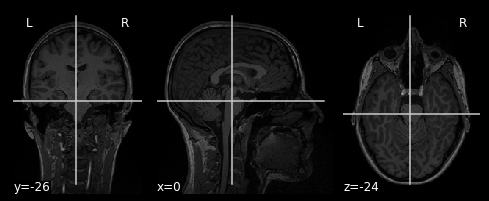

In [4]:
from nilearn import plotting

plotting.plot_anat(T1w)


## 4. Registration of functional images to individual subject and reference template space

We would like to bring all functional images into the same reference space to compare task-based activations or resting state ongoing activity. Usually, we do this by registering the functional and anatomical images of the same individual, aligning the individual anatomical images to a common template and then applying both operations to the fMRI scan. See the figure below for the three-step procedure:
!["Registration"](registration_steps.png)
As discussed in the lecture, there are some drawbacks of this method (e.g. participants may have very different anatomy or may differ in where activation occurs), yet it is still the standard in fMRI research.  

Often, the MNI space is chosen as template space. Here, different versions of template are available, depending on the number and kinds of averages, and whether the template was constructed to be symmetric or asymmetric. See the [MNI ICBM page](http://nist.mni.mcgill.ca/?p=904) for a more detailed description of the available templates, see the [fmriprep documentation](https://fmriprep.org/en/20.1.1/spaces.html?highlight=mni#standard-spaces) for all templates available in `fmriprep`, and [nilearn documentation]() for the templates available in the `nilearn` package.

### 4.1 Co-registration of functional scan to structural T1w scan
Before we perform the co-registration of functional and anatomical scan, we remove the skull and other non-brain tissue from the anatomical scan to achieve a better result.
Like for the functional imaging, we can use `BET` to perform skull-stripping.   


#### Brain extraction

In [5]:
import nipype.interfaces.fsl as fsl
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
from nipype import Node

Extract the brain from the T1w image with `BET`.

In [6]:
bet_T1w=fsl.BET(mask=True)
bet_T1w.inputs.in_file=T1w
bet_T1w.inputs.out_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz"
res=bet_T1w.run()

Take a look at the brain mask and check whether it is correct

/home/jovyan/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


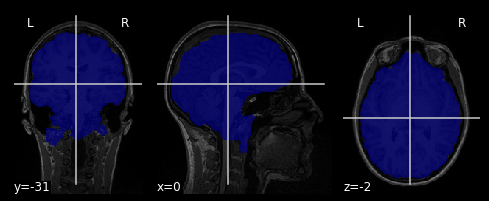

In [7]:
from nilearn.plotting import plot_roi
plot_roi(res.outputs.mask_file,T1w)

Brain extraction did not work perfectly. We see that a part of the neck and brainstem area is still included. We can give `BET` the coordinates of (roughly) the center of gravity (i.e. the middle of the brain) to improve estimation

In [8]:
bet_T1w=fsl.BET(mask=True)
bet_T1w.inputs.in_file=T1w
bet_T1w.inputs.center=[86,106,180]
bet_T1w.inputs.out_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz"
res=bet_T1w.run()

/home/jovyan/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


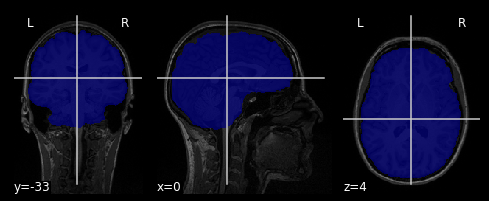

In [9]:
from nilearn.plotting import plot_roi
plot_roi(res.outputs.mask_file,T1w)

Now the brain mask looks fine!

We use this skull-stripped brain to perform the registration with the functional image. If the field-of-view is large (i.e. whole-brain fMRI acquisition), and no calibration has been performed on your scanner (which may cause scaling differences between acquisitions), 6 degrees-of-freedom (i.e. 3 translations + 3 rotations) are appropriate. More answers to frequently asked questions around FLIRT, see [here](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT/FAQ).

Now, we will use  `nipype` to wrap the command in a Node. First, we load the interface for FSL from `nipype.interfaces.fsl`. 

In [10]:
linear_reg = Node(fsl.FLIRT(dof=6, cost_func='mutualinfo'),
                  name='linear_reg')
linear_reg.inputs.in_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz"
linear_reg.inputs.reference="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz"
linear_reg.inputs.out_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.nii.gz"
linear_reg.inputs.out_matrix_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.mat"
linear_reg_res=linear_reg.run()

210610-07:48:58,845 nipype.workflow INFO:
	 [Node] Setting-up "linear_reg" in "/tmp/tmplqpy70ia/linear_reg".
210610-07:48:58,862 nipype.workflow INFO:
	 [Node] Running "linear_reg" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz -ref /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz -out /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.nii.gz -omat /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.mat -searchcost mutualinfo -dof 6
210610-07:49:07,86 nipype.workflow INFO:
	 [Node] Finished "linear_reg".


Look at the result. Unfortunately, the visualization is not ideal in the notebook. If possibly, download these files and have a look at them in `FSLEYES` or `FREEVIEW`.

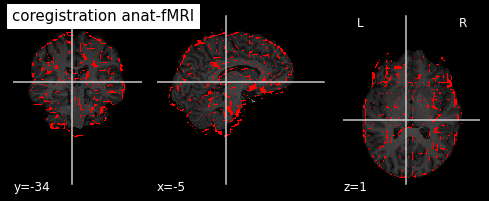

In [11]:
display = plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz", title="coregistration anat-fMRI")
display.add_edges("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.nii.gz")

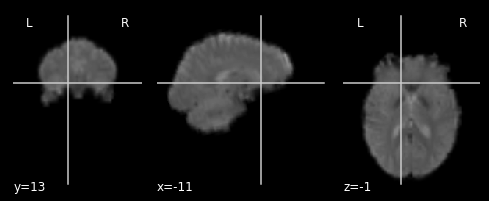

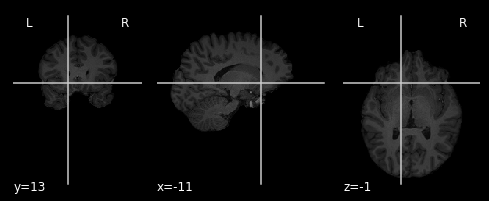

In [12]:
plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.nii.gz", cut_coords=[-11, 13, -1])
plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain_masked.nii.gz", cut_coords=[-11, 13, -1])

#### Exercise 1
Perform the registration of the fMRI to the structural T1w image with 12 degrees of freedom, and compare the results visually.

## 4.2 Non-linear spatial registration of anatomical image and template 

Next, we perform the second step, the non-linear registration of anatomical image and reference template.   
First, we use `nilearn` to fetch the MNI ICBM 2009 template. We use the key `T1` to access the T1-weighted template.

In [14]:
from nilearn import datasets
icbm = datasets.fetch_icbm152_2009()
template_ICBM=icbm['t1']
template_ICBM_mask=icbm['mask']

apply_MNI_mask=fsl.ImageMaths()
apply_MNI_mask.inputs.in_file=template_ICBM
apply_MNI_mask.inputs.mask_file=template_ICBM_mask
apply_MNI_mask.inputs.out_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
apply_MNI_mask.run()

Before we start with the non-linear registration, we perform a "pre" registration step where we rigidly align the T1w image and the MNI template. (You can try and see what happens if you omit this step :))
This step takes quite a while, so please be patient and wait. If you have run it once, you can specify the path to the result files in the following steps.

In [15]:
prereg = Node(fsl.FLIRT(dof=6, cost_func='mutualinfo'),
                  name='prereg')
prereg.inputs.reference="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
prereg.inputs.in_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz"
prereg.inputs.out_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_prereg.nii.gz"
prereg.inputs.out_matrix_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat"
prereg_res=prereg.run()

210610-07:56:05,841 nipype.workflow INFO:
	 [Node] Setting-up "prereg" in "/tmp/tmpxxpzlp07/prereg".
210610-07:56:05,850 nipype.workflow INFO:
	 [Node] Running "prereg" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz -ref /home/jovyan/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz -out /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_prereg.nii.gz -omat /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat -searchcost mutualinfo -dof 6
210610-08:01:30,559 nipype.workflow INFO:
	 [Node] Finished "prereg".


Now, we give this pre-matrix to the non-linear registration function `FNIRT` to perform the non-linear registration of the anatomical image and the MNI space (i.e. changes in size and form of the brain). We use it with its default parameters (see [here](https://nipype.readthedocs.io/en/1.5.0/api/generated/nipype.interfaces.fsl.preprocess.html#fnirt)) in a `nipype` node. `FNIRT` estimates a warp field (i.e. a vector field which describes the displacement of each point). Therefore, it takes quite a long time to run (around 45 minutes on the jupyter hub), so please run it before our session.

In [16]:
import nipype.interfaces.fsl as fsl
from nipype.pipeline.engine import Node
import nipype.interfaces.utility as util

# initiate workflow
nonlinear_reg = Node(fsl.FNIRT(),
                name='nonlinear_reg')
nonlinear_reg.inputs.in_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz"
nonlinear_reg.inputs.ref_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
nonlinear_reg.inputs.affine_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat"
nonlinear_reg.inputs.warped_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni.nii.gz"
nonlinear_reg.inputs.field_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_warpfield.nii.gz"
nonlinear_reg_res=nonlinear_reg.run()

210610-08:10:13,674 nipype.workflow INFO:
	 [Node] Setting-up "nonlinear_reg" in "/tmp/tmpa43c7wun/nonlinear_reg".
210610-08:10:13,686 nipype.workflow INFO:
	 [Node] Running "nonlinear_reg" ("nipype.interfaces.fsl.preprocess.FNIRT"), a CommandLine Interface with command:
fnirt --aff=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_premat.mat --fout=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_warpfield.nii.gz --in=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz --logout=/tmp/tmpa43c7wun/nonlinear_reg/T1w_brain_log.txt --ref=/home/jovyan/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz --iout=/home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni.nii.gz
210610-08:28:43,647 nipype.workflow INFO:
	 [Node] Finished "nonlinear_reg".


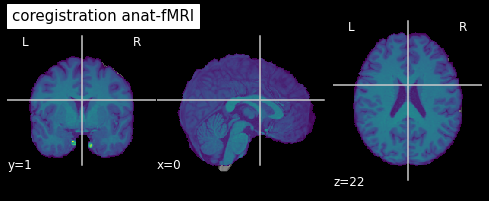

In [39]:
display = plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz", title="coregistration anat-fMRI")
#display.add_edges()
display.add_overlay("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni.nii.gz")

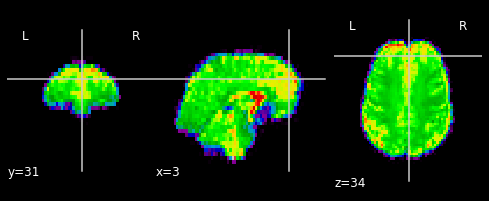

In [45]:
plotting.plot_epi("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz")

To combine both steps and transform our denoised image from the previous session into MNI space, we use the `ApplyWarp` interface. This function combines and applies different registration matrices and warps. As `premat`, we use the tranform from individual fMRI to anatomical space, and as warp file, we use the transform from anatomical to MNI space. Both transforms taken together yield the (mean) fMRI image in MNI space. It would take too long to transform the complete fMRI scan, therefore we use the mean image here.

In [54]:
reg_func2mni = fsl.ApplyWarp()
reg_func2mni.inputs.in_file ="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf_mean_brain.nii.gz"
reg_func2mni.inputs.ref_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz"
reg_func2mni.inputs.field_file = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/t1w_2_mni_warpfield.nii.gz"
reg_func2mni.inputs.premat="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/fmri_to_t1w.mat"
reg_func2mni.inputs.out_file="/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/fmri_denoised_to_mni.nii.gz"
res = reg_func2mni.run() 

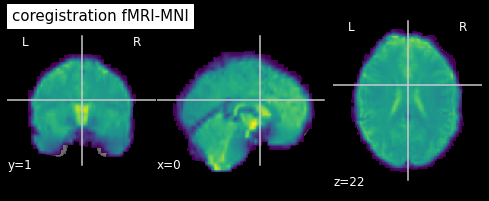

In [56]:
display = plotting.plot_anat("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/ICBM_MNI_masked.nii.gz", title="coregistration fMRI-MNI")
display.add_overlay("/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/func/fmri_denoised_to_mni.nii.gz")

## 4.3 Tissue segmentation
For many approaches it is useful to have the data segmented into tissue types. As described in the aMRI lecture, SPM's `Dartel` or `New Segment` are common approaches to do so, which also allow to run voxel-based morphometry.   
But `FSL` also provides a tool to perform tissue segmentation. We try this for visualization purposes.

In [57]:
fast_seg = fsl.FAST()
fast_seg.inputs.in_files = "/home/" + getpass.getuser() +"/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz"
fast_seg.inputs.img_type = 1
print(fast_seg.cmdline)
fast_seg.run()

fast -t 1 -S 1 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/anat/T1w_brain.nii.gz


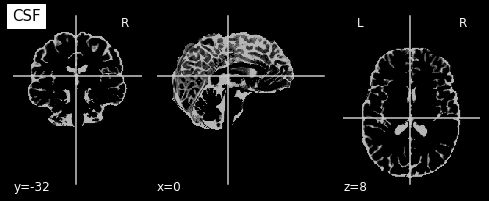

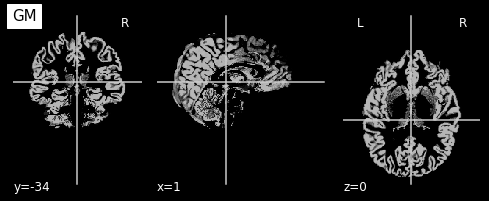

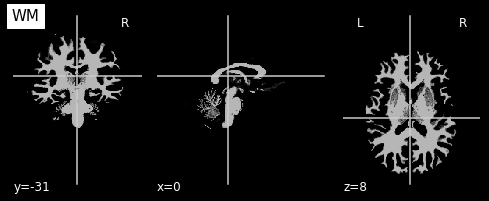

In [58]:
%matplotlib inline
from nilearn import plotting
display = plotting.plot_anat("./fMRI_data/sub-160563d/anat/T1w_brain_pve_0.nii.gz", title="CSF")
display = plotting.plot_anat("./fMRI_data/sub-160563d/anat/T1w_brain_pve_1.nii.gz", title="GM")
display = plotting.plot_anat("./fMRI_data/sub-160563d/anat/T1w_brain_pve_2.nii.gz", title="WM")


## 5. Temporal filtering
Temporal filtering aims to remove frequencies which are not of interest.  
In task-based fMRI, the frequency of interest depends on your design, if e.g. a stimulus is shown every 5 seconds, the frequency of interest would be 0.2 Hz.  
In resting state fMRI, we are interested in low-frequency oscillations (i.e. from 0.01 to 0.1 Hz). Lower frequencies are often related to scanner drift or coil interference, while higher frequencies might be due to physiological noise (respiration at 0.3 Hz, or heart beat at around 1 Hz). 
While high-pass filtering is frequently used to remove low-frequency drifts, low-pass or band-pass filtering is more [controversial](https://en.wikibooks.org/wiki/Neuroimaging_Data_Processing/Temporal_Filtering) and sometimes [not recommended](https://neurostars.org/t/bandpass-filtering-different-outputs-from-fsl-and-nipype-custom-function/824).  
Here, we use the fsl-interface `TemporalFilter` to do high-pass filtering to our denoised data.  
First, we have to calculate the sigma-values for this function which specify the frequency cutoff to be filtered.   

#### Exercise 2
Calculate the variable `sigma_high` for the highpass filter which removes low-frequency noise <0.01 Hz (based on the formula given in this [reference]( https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=ind1205&L=FSL&P=R57592&1=FSL&9=A&I=-3&J=on&d=No+Match%3BMatch%3BMatches&z=4)). You have to use the TR from the `.json` file describing the parameters of the resting state acquisition.

In [18]:
TR=2
HP_freq = 0.01
sigma_high=1 / (2 * TR * HP_freq)

Now, let's run the filtering.

In [19]:
#Perform high-pass filtering to eliminate low-frequency drifts

highpass_filter = Node(fsl.TemporalFilter(out_file='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass.nii.gz'),
                       name='highpass_filter')
highpass_filter.inputs.highpass_sigma=sigma_high
highpass_filter.inputs.in_file='/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz'
hp_res=highpass_filter.run()

210610-09:35:05,828 nipype.workflow INFO:
	 [Node] Setting-up "highpass_filter" in "/tmp/tmpq35c4rnr/highpass_filter".
210610-09:35:05,840 nipype.workflow INFO:
	 [Node] Running "highpass_filter" ("nipype.interfaces.fsl.maths.TemporalFilter"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz -bptf 25.000000 -1.000000 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass.nii.gz
210610-09:35:23,462 nipype.workflow INFO:
	 [Node] Finished "highpass_filter".


In [23]:
img_func_bef_denoising=nib.load('/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_mcf.nii.gz')
img_func_bef_denoising_data=img_func_bef_denoising.get_fdata()
img_func_denoised=nib.load('/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_denoised.nii.gz')
img_func_denoised_data=img_func_denoised.get_fdata()
img_func_hp=nib.load('/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass.nii.gz')
img_func_hp_data=img_func_hp.get_fdata()

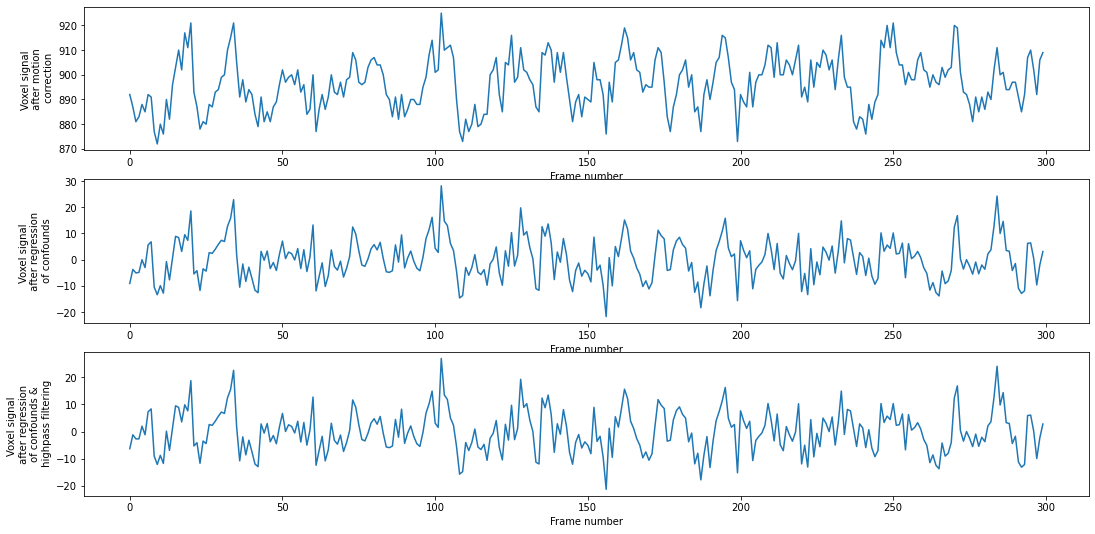

In [68]:
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
fig = Figure(figsize=(18,9))
grid = GridSpec(3,1) 
ax = fig.add_subplot(grid[0,0])
ax.plot(img_func_bef_denoising_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after motion \n correction")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[1,0])
ax.plot(img_func_denoised_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after regression \n of confounds")
ax.set_xlabel("Frame number")
ax = fig.add_subplot(grid[2,0])
ax.plot(img_func_hp_data[32,23,19, :])
ax.set_ylabel("Voxel signal \n after regression \n of confounds & \n highpass filtering")
ax.set_xlabel("Frame number")
fig

We see only little difference between the denoised and highpass-filtered time series. This is because much of the low-frequency drift was already removed in the regression step. Yet, there are small differences, e.g. for the first volumes.

#### Exercise 3
Calculate sigma_high for a low-pass cutoff of 0.1 Hz. Rerun the command above as a bandpass filter (including `highpass_sigma`and `lowpass_sigma`as inputs to the Node) and compare the result in a plot. 

## 6. Smoothing
Spatially smoothing your fMRI has advantages for detecting differences in group-analysis: it improves the signal-to-noise ratio and accounts for local activation differences between individual participants. Usually, you use a Gaussian filter with a kernel size around 4-10 mm. Ideally, filter width matches the expected signal width (fMRI data is inherently smooth because of co-activation and hemodynamic convolution). See also this [page](https://support.brainvoyager.com/brainvoyager/functional-analysis-preparation/29-pre-processing/86-spatial-smoothing) for more information.

In [24]:
# Import IsotropicSmooth from the FSL interface
from nipype.interfaces.fsl import IsotropicSmooth

# Define a node
smooth_node = Node(IsotropicSmooth(), name="smoothing")
smooth_node.inputs.in_file = '/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass.nii.gz'
smooth_node.inputs.fwhm = 4
smooth_node.inputs.out_file = '/home/' + getpass.getuser() +'/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass_4mm.nii.gz'
smooth_res = smooth_node.run()

210610-09:36:18,635 nipype.workflow INFO:
	 [Node] Setting-up "smoothing" in "/tmp/tmpj4tz92tw/smoothing".
210610-09:36:18,647 nipype.workflow INFO:
	 [Node] Running "smoothing" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass.nii.gz -s 1.69864 /home/jovyan/soc_coding_tutorials/fMRI_data/sub-160563d/func/rest_highpass_4mm.nii.gz
210610-09:36:26,372 nipype.workflow INFO:
	 [Node] Finished "smoothing".


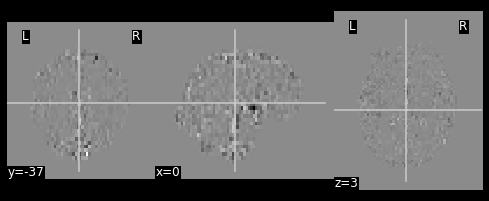

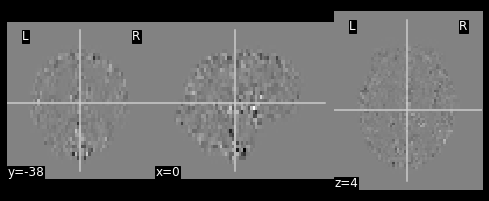

In [25]:
%matplotlib inline
from nilearn.plotting import plot_epi, show
from nilearn.image.image import mean_img
plot_epi(mean_img(smooth_node.inputs.in_file),cmap="gray")
plot_epi(mean_img(smooth_node.inputs.out_file),cmap="gray")

#### Exercise 4
Try smoothing with 6mm and 10mm kernels and compare the results visually. For a better comparison, use a non-denoised image (e.g. the mean after motion correction from the first session) as input.